**Downloading data from kaggle**

In [ ]:
from google.colab import files
files.upload()
!pip install upgrade pip
!pip uninstall -y kaggle
!pip install kaggle==1.5.6
!pip install timm
!pip install albumentations
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 kaggle.json
!kaggle kernels list — user WhatCanWeDo — sort-by dateRun
!kaggle competitions download --force -c journey-springfield

Saving kaggle.json to kaggle.json
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=d622524479c70723ae8bf7d3ca9d288a28f41bac2f6785a77e0f0146de4f5f7a
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
     |████████████████████████████████| 245kB 6.0MB/s 
     |████████████████████████████████| 634kB 5.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f43fbf09b9b31d1662d41fac34924403c5d795574bc81068a0986db1177fb563
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing inst

In [ ]:
!unzip journey-springfield.zip -d journey-springfield 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: journey-springfield/train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: journe

In [ ]:
import pandas as pd
import time
import shutil
import numpy as np
import gc
import torch
import os
import albumentations as A
import pickle
import timm
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


**Custom DataSet**

In [ ]:
DATA_MODES = ['train', 'test', 'val']
RESCALE_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, augmentation=None):
        self.files = files
        self.mode = mode
        self.augmentation = augmentation
        if self.mode not in DATA_MODES:
            raise NameError('Current mode not in data modes')
        self.len = len(self.files)
        if mode == 'val':
            self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
        else:
            self.label_encoder = LabelEncoder()

        if self.mode == 'train':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump:
                pickle.dump(self.label_encoder, le_dump)

    def __len__(self):
        return self.len
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    def show_image(self, index):
        image = self.load_sample(self.files[index])
        image.show()

    def __getitem__(self, index):
        if index < 0 or index > len(self.files):
            raise IndexError()
        image = self.load_sample(self.files[index])
        image = self._prepare_sample(image)
        image = np.array(image / 225, dtype='float32')

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.246, 0.246, 0.246]),
        ])

        image = transform(image)
        if self.mode == 'test':
            return image
        if self.augmentation is not None:
            image = augmentation(image=image)["image"]
        label = self.label_encoder.transform([self.labels[index]]).item()
        return image, label


**Creating loaders**

In [ ]:
TRAIN_DIR = Path("./journey-springfield/train/simpsons_dataset")
TEST_DIR = Path("./journey-springfield/testset/testset")
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [ ]:
def show_image(file, label=None):
    image = Image.open(file)
    if label is None:
        label=''
    plt.imshow(image, label=label)
    #image.show()

journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg


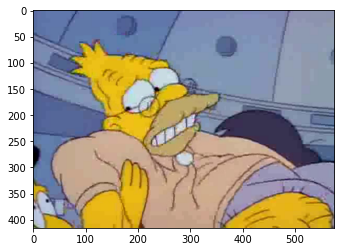

In [ ]:
print(train_val_files[0])
show_image(train_val_files[0], label=train_val_labels[0])

In [ ]:
TRAIN_SIZE = int(0.8 * len(train_val_files))
X_train, X_val, Y_train, Y_val = train_test_split(train_val_files, train_val_labels, train_size=TRAIN_SIZE, shuffle=True)
#print(f'TRAIN: {np.unique(Y_train)}')
#print(f'VAL: {np.unique(Y_val)}')
train_set = SimpsonsDataset(X_train, mode='train')
val_set = SimpsonsDataset(X_val, mode='val')
train_val_loader = {'train' : DataLoader(train_set, batch_size=64),
                    'val' : DataLoader(val_set, batch_size=64)}


20932
{'abraham_grampa_simpson': 0, 'agnes_skinner': 1, 'apu_nahasapeemapetilon': 2, 'barney_gumble': 3, 'bart_simpson': 4, 'carl_carlson': 5, 'charles_montgomery_burns': 6, 'chief_wiggum': 7, 'cletus_spuckler': 8, 'comic_book_guy': 9, 'disco_stu': 10, 'edna_krabappel': 11, 'fat_tony': 12, 'gil': 13, 'groundskeeper_willie': 14, 'homer_simpson': 15, 'kent_brockman': 16, 'krusty_the_clown': 17, 'lenny_leonard': 18, 'lionel_hutz': 19, 'lisa_simpson': 20, 'maggie_simpson': 21, 'marge_simpson': 22, 'martin_prince': 23, 'mayor_quimby': 24, 'milhouse_van_houten': 25, 'miss_hoover': 26, 'moe_szyslak': 27, 'ned_flanders': 28, 'nelson_muntz': 29, 'otto_mann': 30, 'patty_bouvier': 31, 'principal_skinner': 32, 'professor_john_frink': 33, 'rainier_wolfcastle': 34, 'ralph_wiggum': 35, 'selma_bouvier': 36, 'sideshow_bob': 37, 'sideshow_mel': 38, 'snake_jailbird': 39, 'troy_mcclure': 40, 'waylon_smithers': 41}


**Train**

In [ ]:
def vizualize_loss(loss, num_epochs=None):
    if num_epochs is None:
        epochs = range(1, len(loss['train']) + 1)
    else:
        epochs = range(1, num_epochs+1)
    plt.plot(epochs, loss['train'], 'g', label='Training loss')
    plt.plot(epochs, loss['val'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def vizualize_acc(acc, num_epochs=None):
    if num_epochs is None:
        epochs = range(1, len(acc['train']) + 1)
    else:
        epochs = range(1, num_epochs+1)
    plt.plot(epochs, acc['train'], 'g', label='Training acc')
    plt.plot(epochs, acc['val'], 'b' ,label='Validation acc')
    plt.title('Trainining and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def train(model, loader, optimizer, criterion, num_epochs=10, scheduler=None, 
          phases=['train', 'val']):
    '''
    Expect loader to be a dict with 'train' and 'val' keys
    '''

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000.0
    history = {'train' : {'loss' : [], 'acc' :[]}, 
               'val': {'loss' : [], 'acc' : []}}
    for i in range(num_epochs):
        print(f'Epoch: {i+1} / {num_epochs}')
        print('-'*10)
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            processed_size = 0
            for inputs, labels in loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, 1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)          
                processed_size += inputs.size(0)
            
            phase_loss = running_loss / processed_size
            phase_acc = running_corrects.double() / processed_size

            if phase == 'val' and phase_loss < best_loss:
                best_model_wts =copy.deepcopy(model.state_dict())
                best_loss = phase_loss

            print(f'{phase}  loss: {phase_loss}  acc: {phase_acc}')
            history[phase]['loss'].append(phase_loss)
            history[phase]['acc'].append(phase_acc)
    return model, history

In [ ]:
num_classes = len(np.unique(train_val_labels))
model = timm.create_model('tf_efficientnet_b4_ns', pretrained=
                          True, num_classes=num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0075, amsgrad=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


In [ ]:
gc.collect()
num_epochs = 11
model, history = train(model, loader=train_val_loader, num_epochs=num_epochs, optimizer=optimizer, criterion=criterion)

Epoch: 1 / 11
----------
train  loss: 1.0139653755377884  acc: 0.7378654691381616
Epoch: 2 / 11
----------
train  loss: 0.43942438505950177  acc: 0.8832409707624689
Epoch: 3 / 11
----------
train  loss: 0.29105390687472227  acc: 0.9201700745270399
Epoch: 4 / 11
----------
train  loss: 0.20474897360455152  acc: 0.9427670552264475
Epoch: 5 / 11
----------
train  loss: 0.17652086865462288  acc: 0.9477832982992547
Epoch: 6 / 11
----------
train  loss: 0.125498725090451  acc: 0.9642652398241927
Epoch: 7 / 11
----------
train  loss: 0.10841345811287999  acc: 0.9679438180775846
Epoch: 8 / 11
----------
train  loss: 0.09767185780753647  acc: 0.9719568125358303
Epoch: 9 / 11
----------
train  loss: 0.0691058778639063  acc: 0.9793139690426141
Epoch: 10 / 11
----------
train  loss: 0.0592231284414115  acc: 0.9820370724249952
Epoch: 11 / 11
----------
train  loss: 0.058228345601247504  acc: 0.9826103573476017


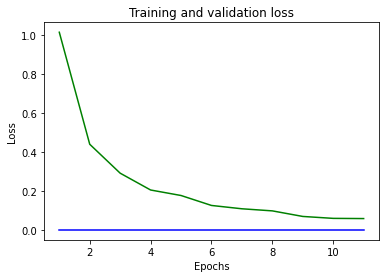

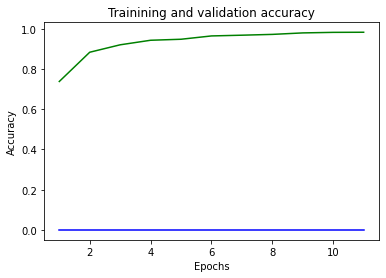

In [ ]:
vizualize_loss({'train': history['train']['loss'], 'val': history['val']['loss']}, num_epochs=num_epochs)
vizualize_acc({'train': history['train']['acc'], 'val': history['val']['acc']}, num_epochs=num_epochs)

**Make submission**


In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_set = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
submit = pd.DataFrame(columns=['Id'])
submit['Id'] = [path.name for path in test_set.files]

probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
submit['Expected'] = preds
submit.head(100)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
95,img184.jpg,lisa_simpson
96,img185.jpg,moe_szyslak
97,img186.jpg,nelson_muntz
98,img187.jpg,marge_simpson


In [ ]:
submit.to_csv('submission.csv', index=False)